C:\Users\ASUS\AppData\Local\Temp\ipykernel_18612\3657202872.py:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


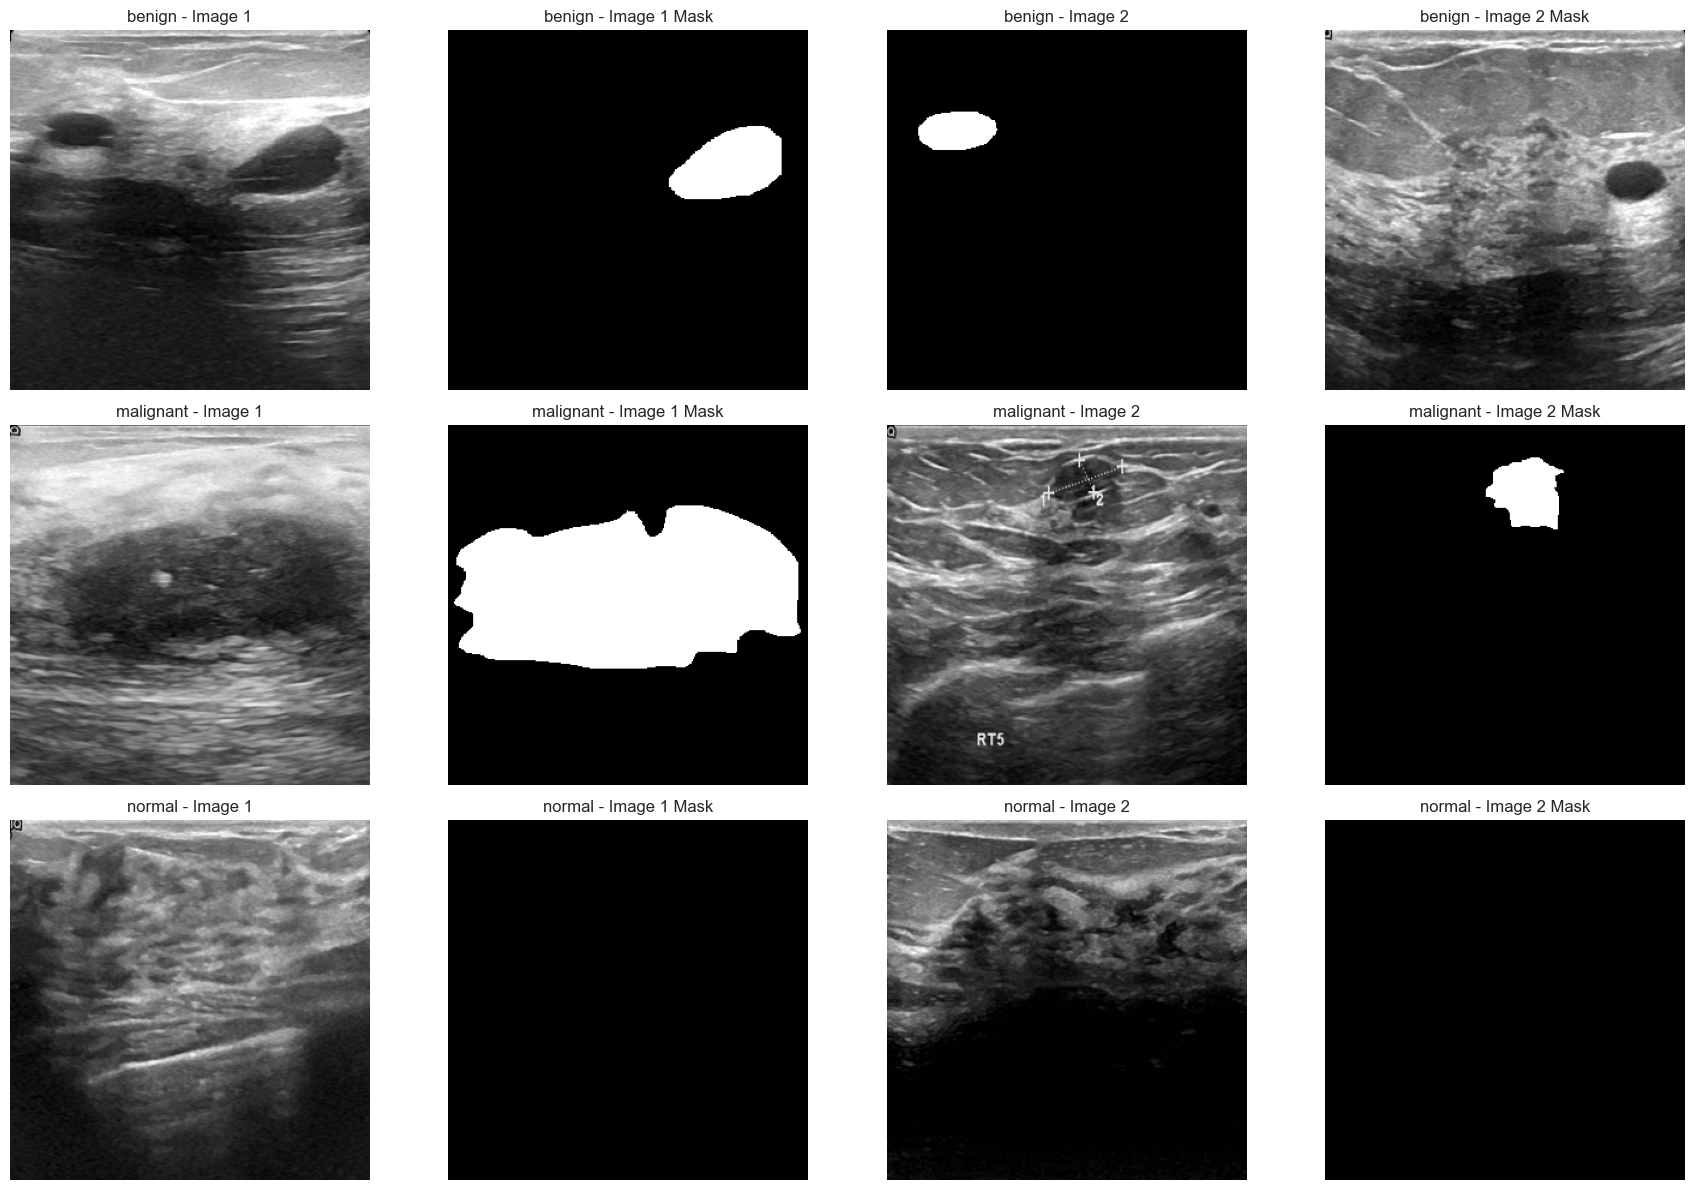

In [6]:
from PIL import Image
import os
import matplotlib.pyplot as plt
# Define the labels and corresponding directories
labels = ['benign', 'malignant', 'normal']
data_dir = r'C:\Users\ASUS\Desktop\DEEPLEARNING PROJECT\Dataset_BUSI_with_GT'

# Create a figure to display the images
fig, axs = plt.subplots(3, 4, figsize=(18, 12))

# Desired width and height for each image
desired_width = 300  # Adjust as needed
desired_height = 300  # Adjust as needed

for i, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)
    
    # Get a list of image files
    image_files = [file for file in os.listdir(label_dir) if file.endswith('.png')]
    
    # Sort the list of image files
    image_files = sorted(image_files)
    
    # Loop through the first 4 image files
    for j in range(4):
        if j < len(image_files):
            # Load and resize the image
            image_path = os.path.join(label_dir, image_files[j])
            image = Image.open(image_path)
            image = image.resize((desired_width, desired_height), Image.ANTIALIAS)
            
            # Determine the label based on whether it's an image or a mask
            if j % 2 == 0:
                image_label = f'{label} - Image {j // 2 + 1}'
            else:
                image_label = f'{label} - Image {j // 2 + 1} Mask'
            
            # Display the image with the corresponding label
            axs[i, j].imshow(image)
            axs[i, j].set_title(image_label)
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

#Approach 1 - Data Split and create folders- excludes mask files

Data Transfornmation and augmentation

In [17]:
import torchvision.transforms as transforms
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# Define the minority classes in your dataset
class_names = ['malignant', 'normal', 'benign']
minority_classes = ['malignant', 'normal']

# Define custom data transformations for minority classes
minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),  # Apply with 90% probability
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Define data transformations for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # Apply custom augmentations to minority classes
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Specify dataset paths
train_dir = r'C:\Users\ASUS\Desktop\DEEPLEARNING PROJECT\Dataset_BUSI_with_GT\train'
validation_dir = r'C:\Users\ASUS\Desktop\DEEPLEARNING PROJECT\Dataset_BUSI_with_GT\validate'
test_dir = r'C:\Users\ASUS\Desktop\DEEPLEARNING PROJECT\Dataset_BUSI_with_GT\test'

# Create datasets for train, validation, and test
image_datasets = {
    x: ImageFolder(
        root=eval(f'{x}_dir'),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

# Specify batch size for dataloaders
batch_size = 8

# Create dataloaders for train, validation, and test
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'validation', 'test']}

# Calculate dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# Print dataset sizes and class labels
print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)



Dataset Sizes: {'train': 561, 'validation': 100, 'test': 117}
Class Labels: ['malignant', 'normal', 'benign']


In [1]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# Set the path to your input folder
data_dir = r'C:\Users\ASUS\Desktop\DEEPLEARNING PROJECT\Dataset_BUSI_with_GT'

# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or 
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

# Define the paths for the train, validation, and test directories
train_dir = r'C:\Users\ASUS\Desktop\DEEPLEARNING PROJECT\Dataset_BUSI_with_GT\train'
val_dir = r'C:\Users\ASUS\Desktop\DEEPLEARNING PROJECT\Dataset_BUSI_with_GT\validate'
test_dir = r'C:\Users\ASUS\Desktop\DEEPLEARNING PROJECT\Dataset_BUSI_with_GT\test'

# Create the train, validation, and test directories and subdirectories
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Copy the images to the corresponding directories
for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))



In [18]:
import os

# Define the base directory for the datasets
base_dir = r'C:\Users\ASUS\Desktop\DEEPLEARNING PROJECT\Dataset_BUSI_with_GT'

# Define the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Function to count image files in a directory
def count_image_files(directory):
    file_counts = {}
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(directory, subdirectory)
        if os.path.exists(subdirectory_path):
            # Filter out non-image files (adjust the extensions if needed)
            image_files = [f for f in os.listdir(subdirectory_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
            file_count = len(image_files)
            file_counts[subdirectory] = file_count
    return file_counts

# Train directory
train_dir = os.path.join(base_dir, 'train')
train_file_counts = count_image_files(train_dir)

# Print the file counts for the train set
for category, count in train_file_counts.items():
    print(f"Train {category}: {count}")

# Validation directory
validation_dir = os.path.join(base_dir, 'validate')
validation_file_counts = count_image_files(validation_dir)

# Print the file counts for the validation set
for category, count in validation_file_counts.items():
    print(f"Validation {category}: {count}")

# Test directory
test_dir = os.path.join(base_dir, 'test')
test_file_counts = count_image_files(test_dir)

# Print the file counts for the test set
for category, count in test_file_counts.items():
    print(f"Test {category}: {count}")



Train benign: 314
Train malignant: 151
Train normal: 96
Validation benign: 56
Validation malignant: 27
Validation normal: 17
Test benign: 65
Test malignant: 32
Test normal: 20


#Ultrasound image approach ---->

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6300\2482441801.py:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


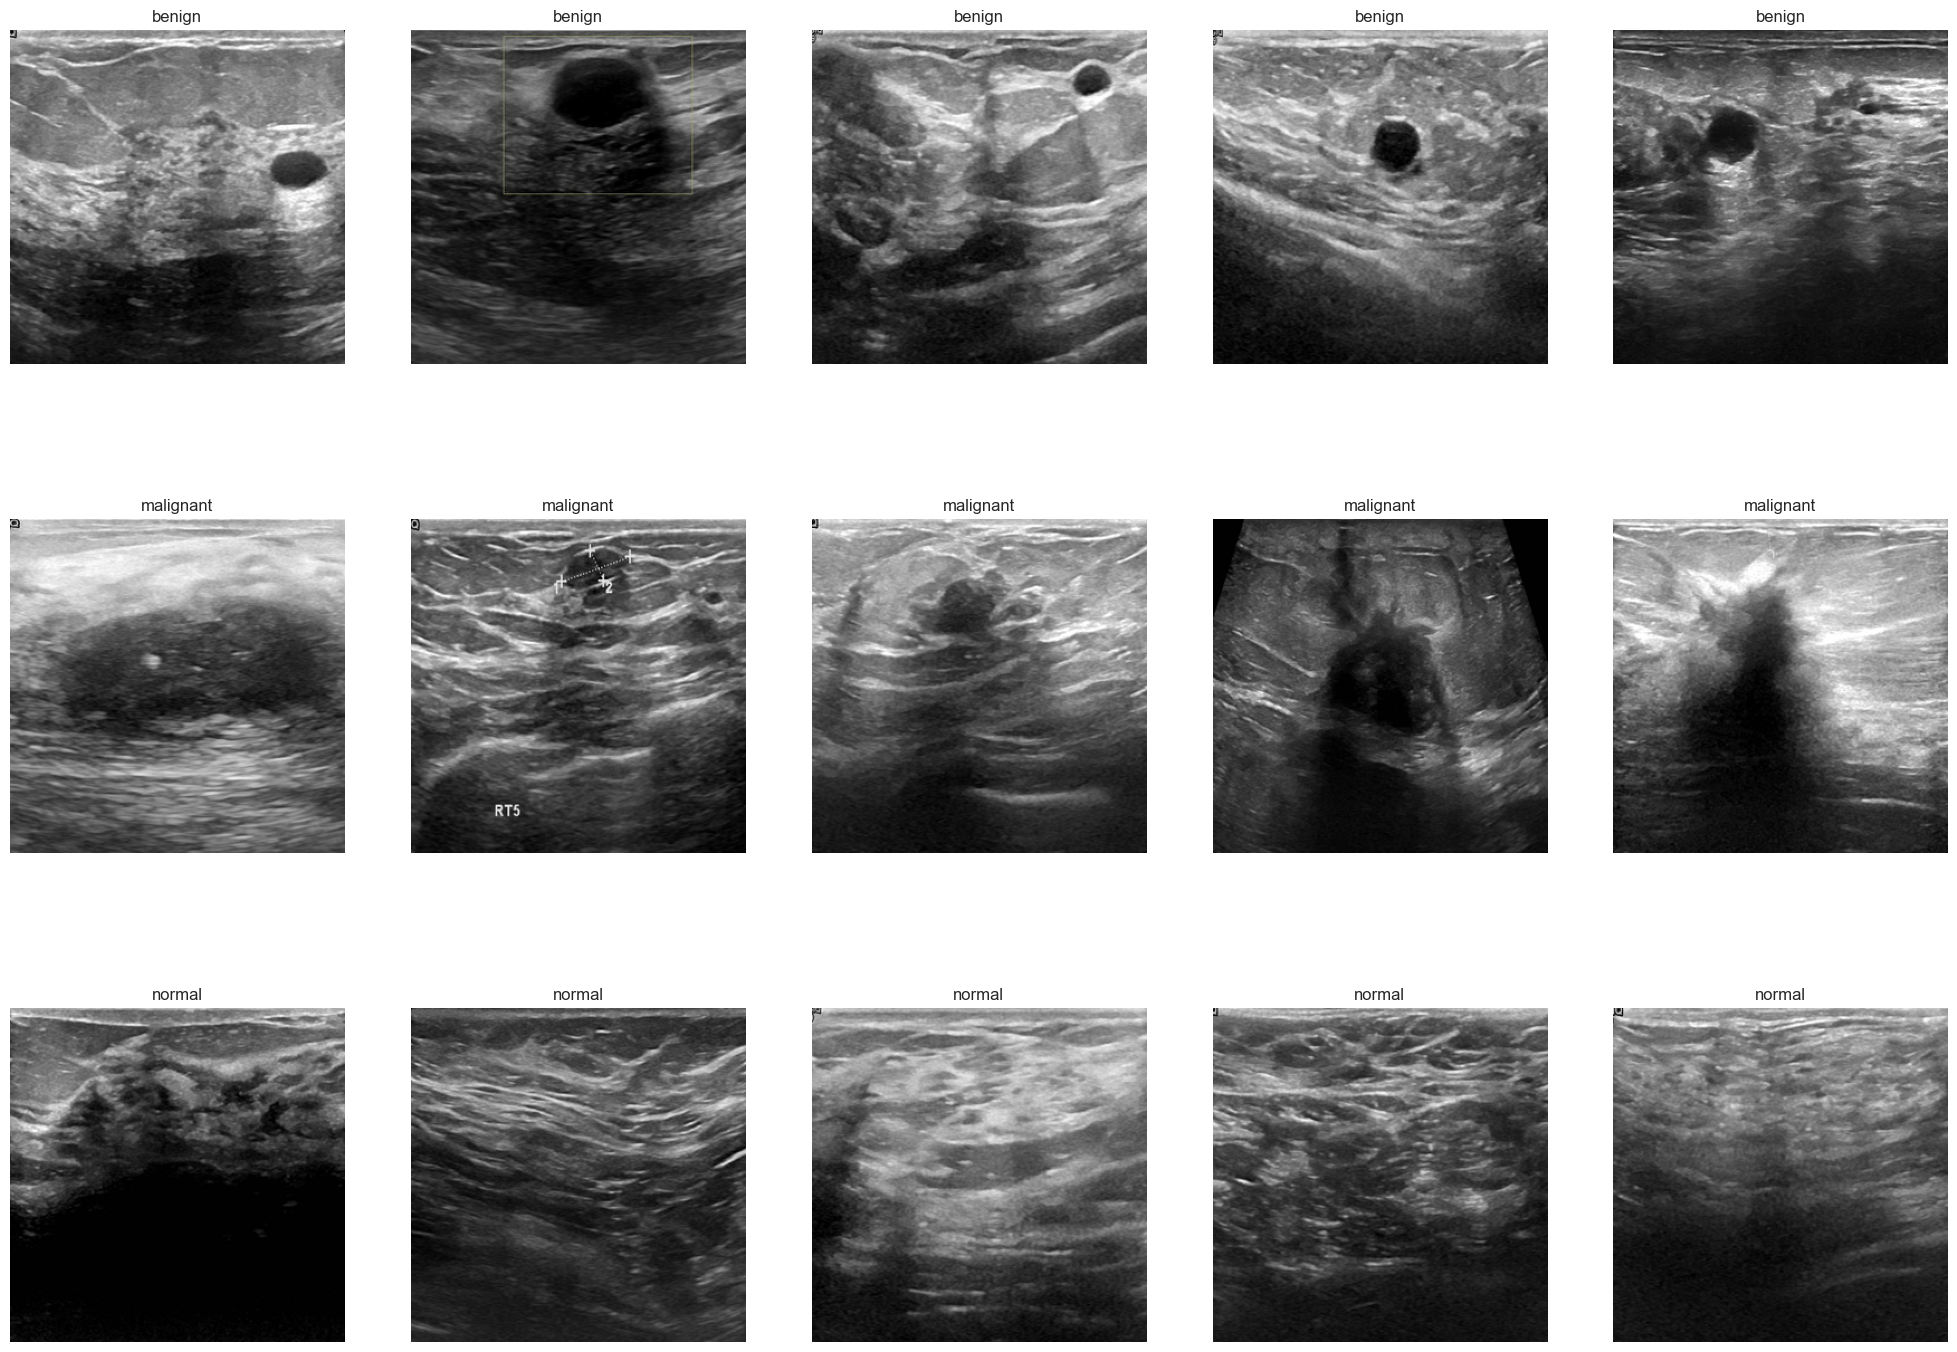

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define the base directory for the datasets
base_dir = r'C:\Users\ASUS\Desktop\DEEPLEARNING PROJECT\Dataset_BUSI_with_GT'

# Define the subdirectories (benign, malignant, normal)
labels = ['benign', 'malignant', 'normal']

# Create a figure to display the images
fig, axs = plt.subplots(len(labels), 5, figsize=(25, 18))

# Desired width and height for each image
desired_width = 300  # Adjust as needed
desired_height = 300  # Adjust as needed

# Loop through each label and display 5 images
for i, label in enumerate(labels):
    label_dir = os.path.join(base_dir, 'train', label)
    
    # Get a list of image files (excluding mask files)
    images = [image for image in os.listdir(label_dir) if not image.endswith('_mask.png')][:5]

    for j, image_filename in enumerate(images):
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)
        
        # Resize the image to the desired width and height
        image = image.resize((desired_width, desired_height), Image.ANTIALIAS)
        
        # Display the image in the subplot
        axs[i, j].imshow(image)
        axs[i, j].set_title(label)
        axs[i, j].axis('off')

plt.show()


#defining model its tasks 

In [10]:
import time
import copy
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Define the training function with early stopping and additional features
def train_model_with_early_stopping(model, loss_function, optimizer, scheduler, train_data, validation_data, class_names, device, num_epochs=20, patience=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model)
    best_loss = float('inf')  # Initialize best_loss with a large value
    consecutive_epochs_without_improvement = 0

    # Lists to store training and validation losses
    train_losses = []
    val_losses = []

    # Define a helper function to iterate over batches
    def process_data(data, model, optimizer, phase):
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in data:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            preds = np.argmax(outputs.cpu().numpy(), axis=1)
            loss = loss_function(outputs, labels)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            if phase == 'train':
                train_losses.append(loss.item())
            else:
                val_losses.append(loss.item())

            running_loss += loss.item() * len(inputs)
            running_corrects += np.sum(preds == labels.cpu().numpy())

        return running_loss, running_corrects

    # Iterate over training epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Process the training data
        train_loss, train_corrects = process_data(train_data, model, optimizer, 'train')
        train_epoch_loss = train_loss / len(train_data)
        train_epoch_acc = train_corrects / len(train_data)
        print(f'Train Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}')

        scheduler.step()

        # Process the validation data
        val_loss, val_corrects = process_data(validation_data, model, optimizer, 'validation')
        val_epoch_loss = val_loss / len(validation_data)
        val_epoch_acc = val_corrects / len(validation_data)
        print(f'Validation Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

        # Early stopping: Check if validation loss improved
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model)
            consecutive_epochs_without_improvement = 0
        else:
            consecutive_epochs_without_improvement += 1

        # Check if early stopping criteria are met
        if consecutive_epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:.4f}')

    # Calculate classification report and confusion matrix for validation data
    y_true = []
    y_pred = []

    best_model_wts.eval()

    for inputs, labels in validation_data:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model_wts(inputs)
        preds = np.argmax(outputs.cpu().numpy(), axis=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

    # Generate classification report
    target_names = [str(class_names[i]) for i in range(len(class_names))]
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    return best_model_wts


#initilaize model 

In [19]:
import torch
import torch.nn as nn
from torchvision import models

# Assuming class_names and device are defined previously
# Replace 'your_device' with 'cuda' for GPU or 'cpu' for CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load ResNet101 pre-trained model
Resnet101 = models.resnet101(pretrained=True)

# Set requires_grad to True for all parameters to enable backpropagation
for param in Resnet101.parameters():
    param.requires_grad = True

# Get the number of input features of ResNet last fully connected layer
in_features = Resnet101.fc.in_features

# Reset the final fully connected layer of the pre-trained ResNet.
# Use nn.Linear(in_features, len(class_names)) instead of nn.Linear(in_features, 1000)
Resnet101.fc = nn.Linear(in_features, len(class_names))

# Move the model to the device (CPU/GPU)
Resnet_fineTuning = Resnet101.to(device)

print(Resnet_fineTuning)


C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#Defining optimizer, hyperparameters and loss function

In [20]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Assuming you have the Resnet_fineTuning model defined earlier

# Define optimization algorithm
optimizer = optim.Adam(Resnet_fineTuning.parameters(), lr=0.00005)

# Decay learning rate by a factor of 0.1 every 7 epochs
decay_learning_rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define loss function
loss_function = nn.CrossEntropyLoss()


 Approach 1 - fine tuning 

In [ ]:
import torch.nn as nn
from torchvision import models

# Assuming you have the Resnet_fineTuning model defined earlier

# Define a new instance of ResNet101
fine_tuned_model = models.resnet101(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in fine_tuned_model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer based on the number of classes in your dataset
num_classes = len(class_names)
in_features = fine_tuned_model.fc.in_features
fine_tuned_model.fc = nn.Linear(in_features, num_classes)

# Load the pre-trained weights from the Resnet_fineTuning model
fine_tuned_model.load_state_dict(Resnet_fineTuning.state_dict())

# Move the fine-tuned model to the device (CPU/GPU)
fine_tuned_model.to(device)

# Define optimization algorithm
optimizer = optim.Adam(fine_tuned_model.parameters(), lr=0.00005)

# Decay learning rate by a factor of 0.1 every 7 epochs
decay_learning_rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define loss function
loss_function = nn.CrossEntropyLoss()

In [ ]:

# Training loop for fine-tuning
num_epochs = 10  # Adjust as needed

for epoch in range(num_epochs):
    # Training phase
    fine_tuned_model.train()
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = fine_tuned_model(inputs)
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Validation phase
    fine_tuned_model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = fine_tuned_model(inputs)
            loss = loss_function(outputs, labels)

    # Learning rate scheduling
    decay_learning_rate.step()



Classification Report:
              precision    recall  f1-score   support

   malignant       0.56      1.00      0.71        65
      normal       0.00      0.00      0.00        32
      benign       0.00      0.00      0.00        20

    accuracy                           0.56       117
   macro avg       0.19      0.33      0.24       117
weighted avg       0.31      0.56      0.40       117


C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

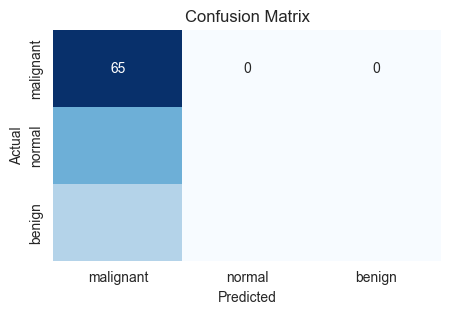

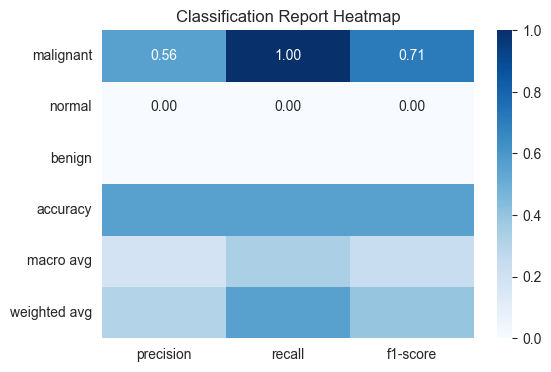

Simplified Classification Report:
           malignant  normal  benign  accuracy  macro avg  weighted avg
precision   0.555556     0.0     0.0  0.555556   0.185185      0.308642
recall      1.000000     0.0     0.0  0.555556   0.333333      0.555556
f1-score    0.714286     0.0     0.0  0.555556   0.238095      0.396825


In [27]:
import seaborn as sns
# Define label names
label_names = [str(class_names[i]) for i in range(len(class_names))]

# Calculate classification report and confusion matrix on unseen test data
y_true = []
y_pred = []

fine_tuned_model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = fine_tuned_model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Generate classification report
classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

# Generate confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with label names
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Convert the classification report to a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')  # Simplify classification report
plt.title('Classification Report Heatmap')
plt.show()

# Print the simplified classification report
print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])  # Display with User



In [ ]:
## Approach 1 - Visualizing results on few samples- Actual vs Prediction

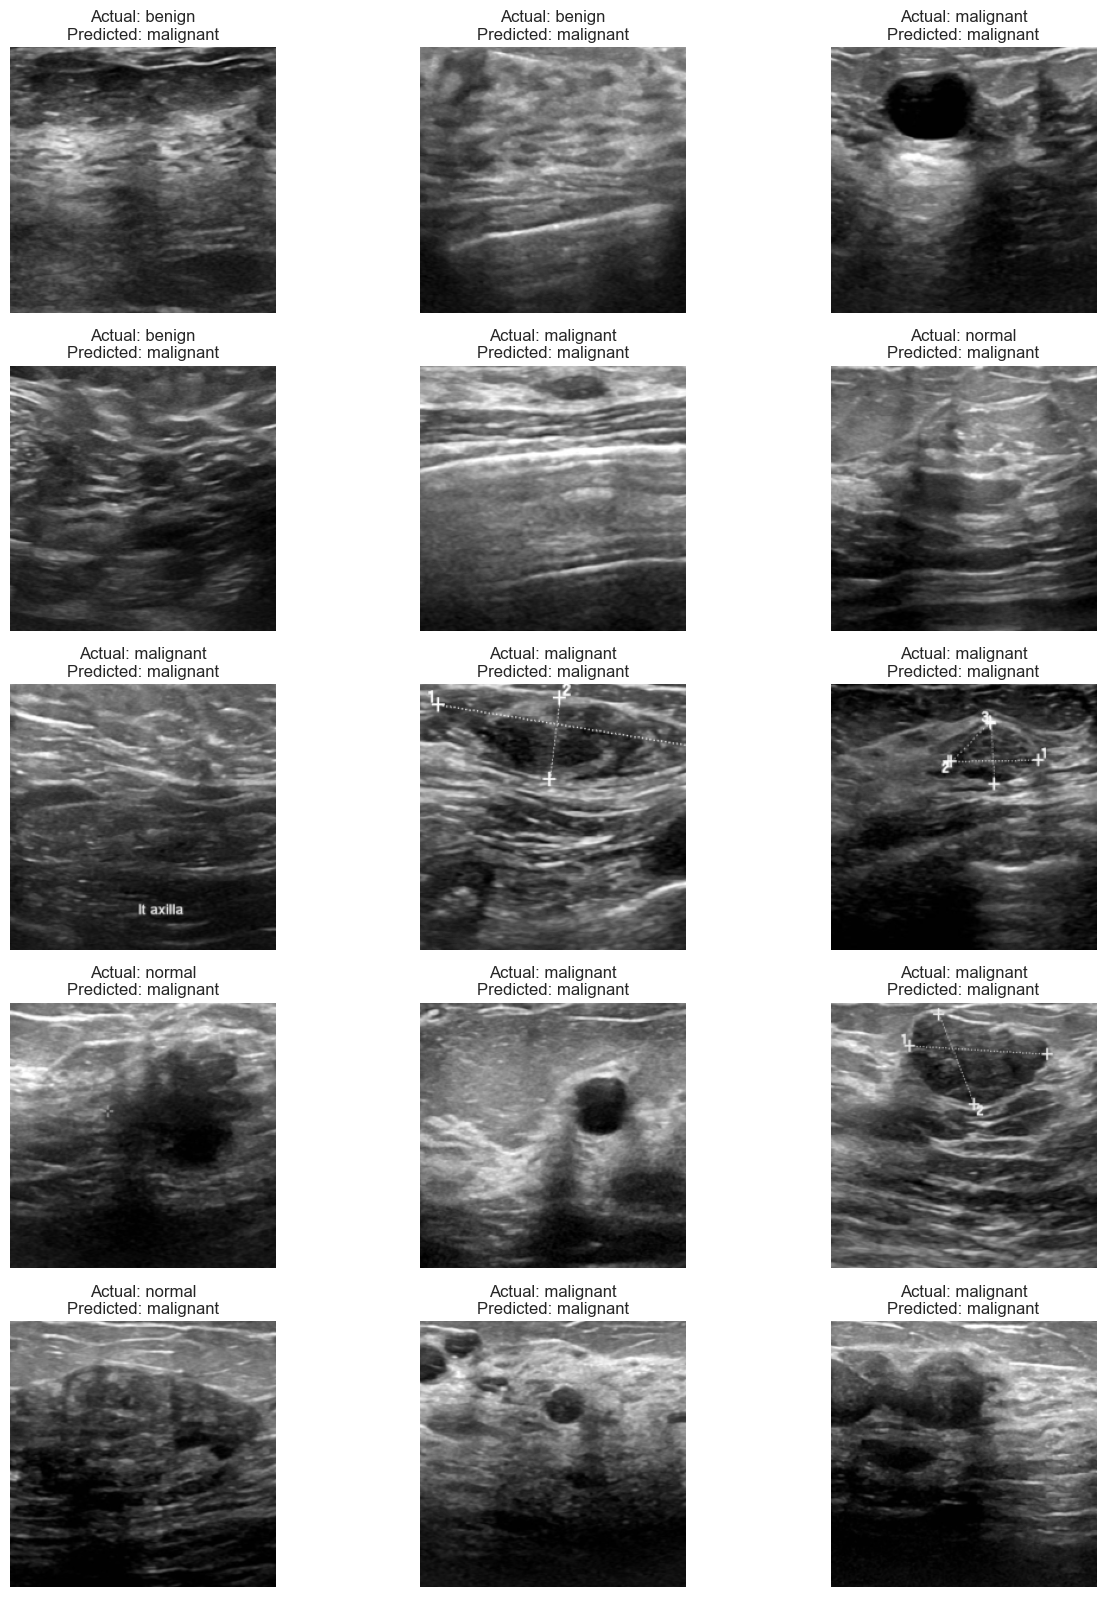

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Set the number of images to display
num_images_to_display = 15

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(image_datasets['test'], batch_size=num_images_to_display, shuffle=True, num_workers=4)

# Get a batch of test data
inputs, labels = next(iter(test_dataloader))

# Move inputs to the device
inputs = inputs.to(device)

# Convert images to grayscale
grayscale_images = inputs.cpu().numpy().mean(axis=1)  # Convert RGB to grayscale

# Get model predictions
with torch.no_grad():
    fine_tuned_model.eval()
    outputs = fine_tuned_model(inputs)
    _, preds = torch.max(outputs, 1)

# Plot the grayscale images with labels and predictions
plt.figure(figsize=(15, 20))  # Increase the height to accommodate 5 rows
for i in range(num_images_to_display):
    ax = plt.subplot(5, 3, i + 1)  # Adjust the layout to 5 rows by 3 columns
    ax.axis('off')
    ax.set_title(f'Actual: {class_names[labels[i]]}\nPredicted: {class_names[preds[i]]}')
    plt.imshow(grayscale_images[i], cmap='gray')  # Display the grayscale image

plt.show()